In [61]:
# Import libraries
import sys
import glob
import os
import random
import math
import json
from collections import defaultdict
from scipy.ndimage.filters import rank_filter
import numpy as np
import pandas as pd
import pytesseract
from PIL import Image, ImageEnhance, ImageFilter, ImageDraw
from io import StringIO    
from skimage import io
from skimage import transform as tf
from skimage.feature import canny
import matplotlib.pyplot as plt
from IPython.display import display
import spacy
import re
import cv2
import argparse

# Set Tesseract path 
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Check tesseract version
## Tesseract 5 was used because it is faster and better than tesseract 4
print("Tesseract 5: " + str(pytesseract.get_tesseract_version()))

#Check cv2 version 
print("OpenCV: " + str(cv2.__version__))

# Test image path 
test_directory_path = "./test_directory_files"
folder_name1 = "/1847.33f67330-5daf-0134-9838-00505686a51c"
folder_name2 = "/1858.4afa0510-317a-0134-cf84-00505686a51c"
folder_name3 = "/1875.4b4b2b90-317a-0134-6800-00505686a51c"
folder_name4 = "/1889.4b939190-317a-0134-d1d5-00505686a51c"
folder_name5 = "/1904.4bc7db80-317a-0134-c859-00505686a51c"

Tesseract 5: 5.0.0-alpha.20191030
OpenCV: 4.1.1



The following chunk draws code from this [site](https://github.com/danvk/oldnyc/blob/master/ocr/tess/crop_morphology.py) with the following [methodology](http://www.danvk.org/2015/01/07/finding-blocks-of-text-in-an-image-using-python-opencv-and-numpy.html) to automate the bounding box creation process. 
I made some modifications to cut out everything but the text. The original code always detected the edge of pages behind the current page as an edge, thus throwing the entire cropping process off-kilter. It works now. Tested on all pages in the test directory. 
It also incorporates code adapted from [here](https://gist.github.com/russss/922be97d2a65eb534744c5a4054ff88d) to straighten any skew introduced in the scanning process. The Probabilistic Hough Line Transform performed here would only detect the center dividing columns. If the original function written by @russss was used wholesale, it will assume that the image is a landscape image and proceed to rotate it 90 degrees; which we do not want! Hence, I took out that bit and the image is nicely deskewed. There is still some skew but I think it is pretty decent.   

In [59]:
def deskew(im, save_directory, max_skew=10):
    height, width = im.shape[:2]
    print(height)
    print(width)

    # Create a grayscale image and denoise it
    im_gs = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im_gs = cv2.fastNlMeansDenoising(im_gs, h=3)

    # Create an inverted B&W copy using Otsu (automatic) thresholding
    im_bw = cv2.threshold(im_gs, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    # Detect lines in this image. Parameters here mostly arrived at by trial and error.
    lines = cv2.HoughLinesP(
        im_bw, 1, np.pi / 180, 200, minLineLength=width / 12, maxLineGap=width / 150
    )

    # Collect the angles of these lines (in radians)
    angles = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        geom = np.arctan2(y2 - y1, x2 - x1)
        print(np.rad2deg(geom))
        angles.append(geom)

    angles = [angle for angle in angles if abs(angle) < np.deg2rad(max_skew)]

    if len(angles) < 5:
        # Insufficient data to deskew
        print("Insufficient data to deskew. Input image might already be straight. Check printout above.")
        return im

    # Average the angles to a degree offset
    angle_deg = np.rad2deg(np.median(angles))

    # Rotate the image by the residual offset
    M = cv2.getRotationMatrix2D((width / 2, height / 2), angle_deg, 1)
    im = cv2.warpAffine(im, M, (width, height), borderMode=cv2.BORDER_REPLICATE)
    
    # Plot and save
    plt.subplot(111),plt.imshow(im)
    plt.title('Deskewed Image'), plt.xticks([]), plt.yticks([])
    plt.show()
    cv2.imwrite(img = im, 
                filename = save_directory + cropped_jpeg[:-5] + "_rotated.jpeg")
    return im

def dilate(ary, N, iterations): 
    """Dilate using an NxN '+' sign shape. ary is np.uint8."""
    kernel = np.zeros((N,N), dtype=np.uint8)
    kernel[(N-1)//2,:] = 1
    dilated_image = cv2.dilate(ary / 255, kernel, iterations=iterations)

    kernel = np.zeros((N,N), dtype=np.uint8)
    kernel[:,(N-1)//2] = 1
    dilated_image = cv2.dilate(dilated_image, kernel, iterations=iterations)
    
    plt.subplot(111),plt.imshow(dilated_image,cmap = 'gray')
    plt.title('Dilated Image'), plt.xticks([]), plt.yticks([])
    plt.show()
    
    return dilated_image

def find_components(edges, max_components=16):
    """Dilate the image until there are just a few connected components.
    Returns contours for these components."""
    # Perform increasingly aggressive dilation until there are just a few
    # connected components.
    count = 410
    dilation = 5
    n = 1
    while count > 400:
        n += 1
        dilated_image = dilate(edges, N=3, iterations=n)
#         print(dilated_image.dtype)
        dilated_image = cv2.convertScaleAbs(dilated_image)
#         print(dilated_image.dtype)
        contours, hierarchy = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        count = len(contours)
        print(count)
    #print dilation
    #Image.fromarray(edges).show()
    #Image.fromarray(255 * dilated_image).show()
    return contours

def props_for_contours(contours, ary):
    """Calculate bounding box & the number of set pixels for each contour."""
    c_info = []
    for c in contours:
        x,y,w,h = cv2.boundingRect(c)
        c_im = np.zeros(ary.shape)
        cv2.drawContours(c_im, [c], 0, 255, -1)
        c_info.append({
            'x1': x,
            'y1': y,
            'x2': x + w - 1,
            'y2': y + h - 1,
            'sum': np.sum(ary * (c_im > 0))/255
        })
    return c_info

def union_crops(crop1, crop2):
    """Union two (x1, y1, x2, y2) rects."""
    x11, y11, x21, y21 = crop1
    x12, y12, x22, y22 = crop2
    return min(x11, x12), min(y11, y12), max(x21, x22), max(y21, y22)


def intersect_crops(crop1, crop2):
    x11, y11, x21, y21 = crop1
    x12, y12, x22, y22 = crop2
    return max(x11, x12), max(y11, y12), min(x21, x22), min(y21, y22)


def crop_area(crop):
    x1, y1, x2, y2 = crop
    return max(0, x2 - x1) * max(0, y2 - y1)


def find_border_components(contours, ary):
    borders = []
    area = ary.shape[0] * ary.shape[1]
    for i, c in enumerate(contours):
        x,y,w,h = cv2.boundingRect(c)
        if w * h > 0.5 * area:
            borders.append((i, x, y, x + w - 1, y + h - 1))
    return borders


def angle_from_right(deg):
    return min(deg % 90, 90 - (deg % 90))


def remove_border(contour, ary):
    """Remove everything outside a border contour."""
    # Use a rotated rectangle (should be a good approximation of a border).
    # If it's far from a right angle, it's probably two sides of a border and
    # we should use the bounding box instead.
    c_im = np.zeros(ary.shape)
    r = cv2.minAreaRect(contour)
    degs = r[2]
    if angle_from_right(degs) <= 10.0:
        box = cv2.cv.BoxPoints(r)
        box = np.int0(box)
        cv2.drawContours(c_im, [box], 0, 255, -1)
        cv2.drawContours(c_im, [box], 0, 0, 4)
    else:
        x1, y1, x2, y2 = cv2.boundingRect(contour)
        cv2.rectangle(c_im, (x1, y1), (x2, y2), 255, -1)
        cv2.rectangle(c_im, (x1, y1), (x2, y2), 0, 4)

    return np.minimum(c_im, ary)

def find_optimal_components_subset(contours, edges):
    """Find a crop which strikes a good balance of coverage/compactness.
    Returns an (x1, y1, x2, y2) tuple.
    """
    c_info = props_for_contours(contours, edges)
    c_info.sort(key=lambda x: -x['sum'])
    total = np.sum(edges) / 255
    area = edges.shape[0] * edges.shape[1]

    c = c_info[0]
    del c_info[0]
    this_crop = c['x1'], c['y1'], c['x2'], c['y2']
    crop = this_crop
    covered_sum = c['sum']

    while covered_sum < total:
        changed = False
        recall = 1.0 * covered_sum / total
        prec = 1 - 1.0 * crop_area(crop) / area
        f1 = 2 * (prec * recall / (prec + recall))
        #print '----'
        for i, c in enumerate(c_info):
            this_crop = c['x1'], c['y1'], c['x2'], c['y2']
            new_crop = union_crops(crop, this_crop)
            new_sum = covered_sum + c['sum']
            new_recall = 1.0 * new_sum / total
            new_prec = 1 - 1.0 * crop_area(new_crop) / area
            new_f1 = 2 * new_prec * new_recall / (new_prec + new_recall)

            # Add this crop if it improves f1 score,
            # _or_ it adds 25% of the remaining pixels for <15% crop expansion.
            # ^^^ very ad-hoc! make this smoother
            remaining_frac = c['sum'] / (total - covered_sum)
            new_area_frac = 1.0 * crop_area(new_crop) / crop_area(crop) - 1
            if new_f1 > f1 or (remaining_frac > 0.25 and new_area_frac < 0.15):
                print ('%d %s -> %s / %s (%s), %s -> %s / %s (%s), %s -> %s' % (
                        i, covered_sum, new_sum, total, remaining_frac,
                        crop_area(crop), crop_area(new_crop), area, new_area_frac,
                        f1, new_f1))
                crop = new_crop
                covered_sum = new_sum
                del c_info[i]
                changed = True
                break

        if not changed:
            break

    return crop

def pad_crop(crop, contours, edges, border_contour, pad_px=15):
    """Slightly expand the crop to get full contours.
    This will expand to include any contours it currently intersects, but will
    not expand past a border.
    """
    bx1, by1, bx2, by2 = 0, 0, edges.shape[0], edges.shape[1]
    if border_contour is not None and len(border_contour) > 0:
        c = props_for_contours([border_contour], edges)[0]
        bx1, by1, bx2, by2 = c['x1'] + 5, c['y1'] + 5, c['x2'] - 5, c['y2'] - 5

    def crop_in_border(crop):
        x1, y1, x2, y2 = crop
        x1 = max(x1 - pad_px, bx1)
        y1 = max(y1 - pad_px, by1)
        x2 = min(x2 + pad_px, bx2)
        y2 = min(y2 + pad_px, by2)
        return crop
    
    crop = crop_in_border(crop)

    c_info = props_for_contours(contours, edges)
    changed = False
    for c in c_info:
        this_crop = c['x1'], c['y1'], c['x2'], c['y2']
        this_area = crop_area(this_crop)
        int_area = crop_area(intersect_crops(crop, this_crop))
        new_crop = crop_in_border(union_crops(crop, this_crop))
        if 0 < int_area < this_area and crop != new_crop:
            print ('%s -> %s' % (str(crop), str(new_crop)))
            changed = True
            crop = new_crop

    if changed:
        return pad_crop(crop, contours, edges, border_contour, pad_px)
    else:
        return crop

def downscale_image(im, max_dim=2048):
    """Shrink im until its longest dimension is <= max_dim.
    Returns new_image, scale (where scale <= 1).
    """
    a, b = im.size
    if max(a, b) <= max_dim:
        return 1.0, im

    scale = 1.0 * max_dim / max(a, b)
    new_im = im.resize((int(a * scale), int(b * scale)), Image.ANTIALIAS)
    return scale, new_im      
    
def process_image(path, out_path):
    
    
    uncropped_jpeg = ""
    cropped_jpeg = ""
    for file in os.listdir(path):
        if file.endswith('.jpeg'):
            uncropped_jpeg = "/" + file
            #print (uncropped_jpeg)
            cropped_jpeg = uncropped_jpeg[:-5] + "_cropped.jpeg"
            #print(cropped_jpeg)
        
        
    orig_im = Image.open(path + uncropped_jpeg)
    scale, im = downscale_image(orig_im)
        
    # Apply dilation and erosion to remove some noise    
    kernel = np.ones((1, 1), np.uint8)    
    img = cv2.dilate(np.asarray(im), kernel, iterations=1)    
    img = cv2.erode(img, kernel, iterations=1) 
    
    # Detect edge and plot
    edges = cv2.Canny(img, 100, 400)
    
    plt.subplot(111),plt.imshow(edges,cmap = 'gray')
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

    plt.show()

    # TODO: dilate image _before_ finding a border. This is crazy sensitive!
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    borders = find_border_components(contours, edges)
    borders.sort(key=lambda i, x1, y1, x2, y2: (x2 - x1) * (y2 - y1))

    border_contour = None
    if len(borders):
        border_contour = contours[borders[0][0]]
        edges = remove_border(border_contour, edges)

    edges = 255 * (edges > 0).astype(np.uint8)

    # Remove ~1px borders using a rank filter.
    maxed_rows = rank_filter(edges, -4, size=(1, 20))
    maxed_cols = rank_filter(edges, -4, size=(20, 1))
    debordered = np.minimum(np.minimum(edges, maxed_rows), maxed_cols)
    edges = debordered

    contours = find_components(edges)
    if len(contours) == 0:
#        print '%s -> (no text!)' % path
        return

    crop = find_optimal_components_subset(contours, edges)
    crop = pad_crop(crop, contours, edges, border_contour)

    crop = [int(x / scale) for x in crop]  # upscale to the original image size.
    draw = ImageDraw.Draw(im)
    c_info = props_for_contours(contours, edges)
    for c in c_info:
        this_crop = c['x1'], c['y1'], c['x2'], c['y2']
        draw.rectangle(this_crop, outline='blue')
    draw.rectangle(crop, outline='red')
    im.save(out_path + cropped_jpeg)
    draw.text((50, 50), path, fill='red')
    orig_im.save(out_path + cropped_jpeg)
    im.show()
    text_im = orig_im.crop(crop)
    text_im.save(out_path + cropped_jpeg)
#    print '%s -> %s' % (path, out_path)

    # Deskew image 
    cropped_image = cv2.imread(out_path + cropped_jpeg)
    print("Cropped image read")
    deskewed_image = deskew(im = cropped_image, 
                            save_directory = out_path)

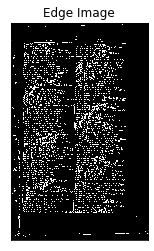

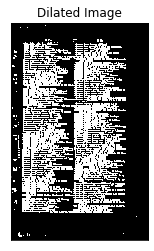

1305


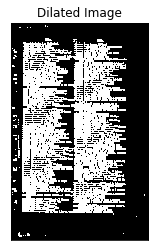

752


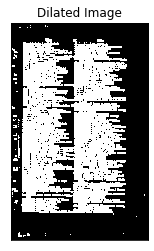

1358


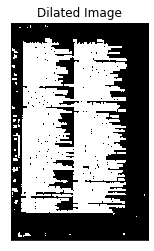

647


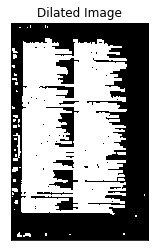

366
0 208793.0 -> 209133.0 / 212228.0 (0.09898107714701601), 1638420 -> 1638420 / 2643968 (0.0), 0.5485716442949019 -> 0.5488204020928545
0 209133.0 -> 209439.0 / 212228.0 (0.0988691437802908), 1638420 -> 1638420 / 2643968 (0.0), 0.5488204020928545 -> 0.5490437856576287
1 209439.0 -> 209705.0 / 212228.0 (0.09537468626747939), 1638420 -> 1638420 / 2643968 (0.0), 0.5490437856576287 -> 0.5492375862996843
2 209705.0 -> 209901.0 / 212228.0 (0.07768529528339278), 1638420 -> 1638420 / 2643968 (0.0), 0.5492375862996843 -> 0.5493801597583406
11 209901.0 -> 209971.0 / 212228.0 (0.030081650193382038), 1638420 -> 1638420 / 2643968 (0.0), 0.5493801597583406 -> 0.5494310322556928
16 209971.0 -> 210031.0 / 212228.0 (0.02658396101019052), 1638420 -> 1638420 / 2643968 (0.0), 0.5494310322556928 -> 0.5494746177564473
16 210031.0 -> 210078.0 / 212228.0 (0.021392808375056895), 1638420 -> 1638420 / 2643968 (0.0), 0.5494746177564473 -> 0.54950874716914
Cropped image read
4114
2446
-90.0
-90.0
-88.93662736224

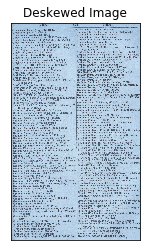

In [60]:
process_image(test_directory_path + folder_name1, test_directory_path + folder_name1)

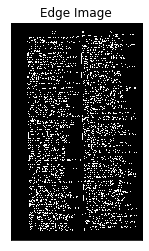

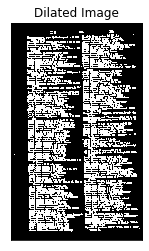

1827


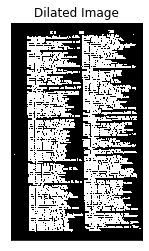

864


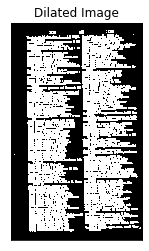

779


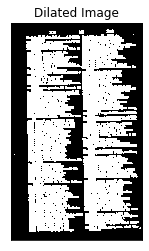

844


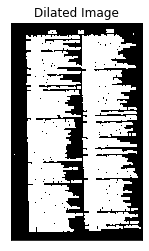

508


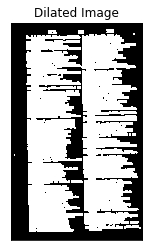

273
0 201461.0 -> 201816.0 / 204482.0 (0.11751075802714334), 1949744 -> 1949744 / 2529280 (0.0), 0.37179458463378634 -> 0.3719180249850258
0 201816.0 -> 202134.0 / 204482.0 (0.11927981995498875), 1949744 -> 1949744 / 2529280 (0.0), 0.3719180249850258 -> 0.3720283008440993
0 202134.0 -> 202383.0 / 204482.0 (0.10604770017035775), 1949744 -> 1949744 / 2529280 (0.0), 0.3720283008440993 -> 0.37211445248477615
0 202383.0 -> 202600.0 / 204482.0 (0.10338256312529776), 1949744 -> 1949744 / 2529280 (0.0), 0.37211445248477615 -> 0.37218939217283603
0 202600.0 -> 202805.0 / 204482.0 (0.10892667375132838), 1949744 -> 1949744 / 2529280 (0.0), 0.37218939217283603 -> 0.37226006806413664
6 202805.0 -> 202944.0 / 204482.0 (0.0828861061419201), 1949744 -> 1949744 / 2529280 (0.0), 0.37226006806413664 -> 0.3723079237722279
6 202944.0 -> 203075.0 / 204482.0 (0.08517555266579974), 1949744 -> 1949744 / 2529280 (0.0), 0.3723079237722279 -> 0.37235297647141746
6 203075.0 -> 203191.0 / 204482.0 (0.08244491826581

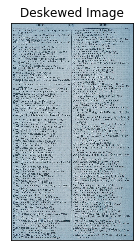

In [40]:
process_image(test_directory_path + folder_name2, test_directory_path + folder_name2)

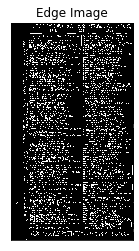

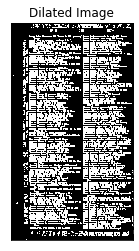

2293


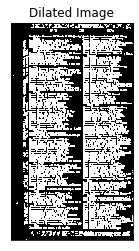

914


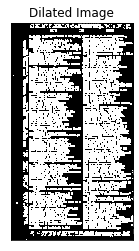

688


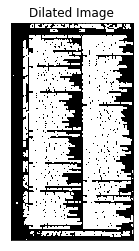

984


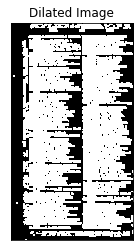

594


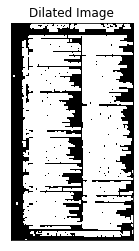

385
0 200915.0 -> 203271.0 / 209342.0 (0.27957754835647325), 1914948 -> 1983786 / 2355200 (0.03594771241830075), 0.3129103778103663 -> 0.27133219191271085
1 203271.0 -> 203791.0 / 209342.0 (0.08565310492505353), 1983786 -> 1983786 / 2355200 (0.0), 0.27133219191271085 -> 0.2714289588056942
1 203791.0 -> 204247.0 / 209342.0 (0.08214736083588543), 1983786 -> 1983786 / 2355200 (0.0), 0.2714289588056942 -> 0.2715134668565877
0 204247.0 -> 205590.0 / 209342.0 (0.2635917566241413), 1983786 -> 2096430 / 2355200 (0.056782334384858135), 0.2715134668565877 -> 0.19763297675365735
0 205590.0 -> 206015.0 / 209342.0 (0.113272921108742), 2096430 -> 2096430 / 2355200 (0.0), 0.19763297675365735 -> 0.1976740088264135
1 206015.0 -> 206410.0 / 209342.0 (0.11872557859933874), 2096430 -> 2096430 / 2355200 (0.0), 0.1976740088264135 -> 0.19771200820632642
1 206410.0 -> 206791.0 / 209342.0 (0.12994542974079126), 2096430 -> 2096430 / 2355200 (0.0), 0.19771200820632642 -> 0.19774853699814662
1 206791.0 -> 207090.

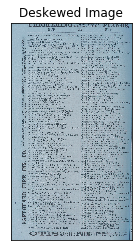

In [41]:
process_image(test_directory_path + folder_name3, test_directory_path + folder_name3)

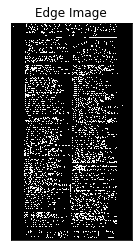

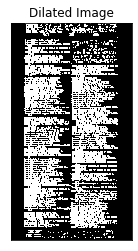

1865


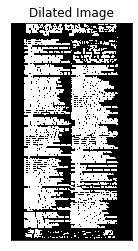

1271


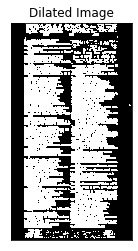

1146


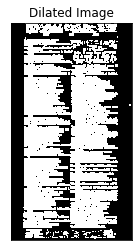

650


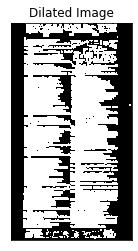

356
0 190825.0 -> 194503.0 / 205199.0 (0.2558786698205093), 1583310 -> 1723040 / 2330624 (0.08825182686902755), 0.47687249296658585 -> 0.4089244362196917
0 194503.0 -> 197478.0 / 205199.0 (0.2781413612565445), 1723040 -> 1808224 / 2330624 (0.04943820224719109), 0.4089244362196917 -> 0.36360487675504327
0 197478.0 -> 199738.0 / 205199.0 (0.2927081984198938), 1808224 -> 1808224 / 2330624 (0.0), 0.36360487675504327 -> 0.36438374313660915
1 199738.0 -> 200396.0 / 205199.0 (0.1204907526094122), 1808224 -> 1808224 / 2330624 (0.0), 0.36438374313660915 -> 0.36460782482601245
1 200396.0 -> 200976.0 / 205199.0 (0.12075785967103893), 1808224 -> 1808224 / 2330624 (0.0), 0.36460782482601245 -> 0.3648043535291662
0 200976.0 -> 202067.0 / 205199.0 (0.2583471465782619), 1808224 -> 1893218 / 2330624 (0.04700413223140498), 0.3648043535291662 -> 0.3152691865515291
0 202067.0 -> 202479.0 / 205199.0 (0.13154533844189017), 1893218 -> 1893218 / 2330624 (0.0), 0.3152691865515291 -> 0.315371910478771
1 202479.

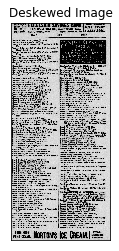

In [42]:
process_image(test_directory_path + folder_name4, test_directory_path + folder_name4)

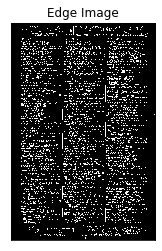

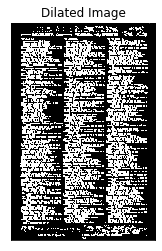

2159


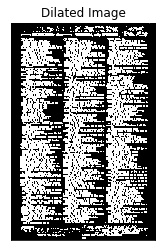

1551


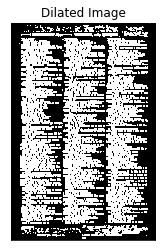

1152


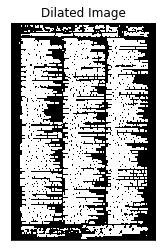

1174


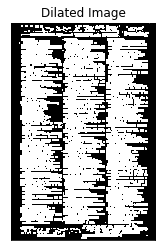

910


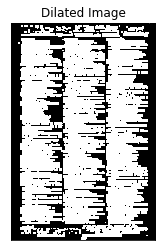

457


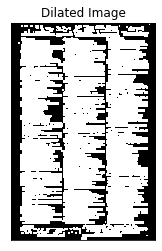

185
8 158862.0 -> 159121.0 / 246939.0 (0.0029406087854945105), 1411020 -> 1411020 / 2789376 (0.0), 0.5589523725589689 -> 0.5593478928225631
8 159121.0 -> 159348.0 / 246939.0 (0.002584891480106584), 1411020 -> 1411020 / 2789376 (0.0), 0.5593478928225631 -> 0.5596939469604707
9 159348.0 -> 159503.0 / 246939.0 (0.0017695881997008825), 1411020 -> 1411020 / 2789376 (0.0), 0.5596939469604707 -> 0.5599299188111867
11 159503.0 -> 159638.0 / 246939.0 (0.0015439864586669107), 1411020 -> 1411020 / 2789376 (0.0), 0.5599299188111867 -> 0.5601352310729414
15 159638.0 -> 159752.0 / 246939.0 (0.0013058269664723199), 1411020 -> 1411020 / 2789376 (0.0), 0.5601352310729414 -> 0.560308452663613
16 159752.0 -> 159836.0 / 246939.0 (0.0009634463853556149), 1411020 -> 1411020 / 2789376 (0.0), 0.560308452663613 -> 0.5604359999630961
16 159836.0 -> 159903.0 / 246939.0 (0.0007692042753980919), 1411020 -> 1411020 / 2789376 (0.0), 0.5604359999630961 -> 0.5605376796297922
19 159903.0 -> 159945.0 / 246939.0 (0.00048

In [56]:
process_image(test_directory_path + folder_name5, test_directory_path + folder_name5)

In [ ]:
import argparse

def process_image(args):
    
    import sys
    import glob
    import os
    import random
    import math
    import json
    from collections import defaultdict
    from scipy.ndimage.filters import rank_filter
    import numpy as np
    import pandas as pd
    import pytesseract
    from PIL import Image, ImageEnhance, ImageFilter, ImageDraw
    from io import StringIO    
    from skimage import io
    from skimage import transform as tf
    from skimage.feature import canny
    import matplotlib.pyplot as plt
    from IPython.display import display
    import spacy
    import re
    import cv2
    
    path = args.input
    out_path = args.output
    
    def deskew(im, save_directory, max_skew=10):
        height, width = im.shape[:2]
        print(height)
        print(width)

        # Create a grayscale image and denoise it
        im_gs = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        im_gs = cv2.fastNlMeansDenoising(im_gs, h=3)

        # Create an inverted B&W copy using Otsu (automatic) thresholding
        im_bw = cv2.threshold(im_gs, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

        # Detect lines in this image. Parameters here mostly arrived at by trial and error.
        lines = cv2.HoughLinesP(
            im_bw, 1, np.pi / 180, 200, minLineLength=width / 12, maxLineGap=width / 150
        )

        # Collect the angles of these lines (in radians)
        angles = []
        for line in lines:
            x1, y1, x2, y2 = line[0]
            geom = np.arctan2(y2 - y1, x2 - x1)
            print(np.rad2deg(geom))
            angles.append(geom)

        angles = [angle for angle in angles if abs(angle) < np.deg2rad(max_skew)]

        if len(angles) < 5:
            # Insufficient data to deskew
            print("Insufficient data to deskew. Input image might already be straight. Check printout above.")
            return im

        # Average the angles to a degree offset
        angle_deg = np.rad2deg(np.median(angles))

        # Rotate the image by the residual offset
        M = cv2.getRotationMatrix2D((width / 2, height / 2), angle_deg, 1)
        im = cv2.warpAffine(im, M, (width, height), borderMode=cv2.BORDER_REPLICATE)

        # Plot and save
        plt.subplot(111),plt.imshow(im)
        plt.title('Deskewed Image'), plt.xticks([]), plt.yticks([])
        plt.show()
        cv2.imwrite(img = im, 
                    filename = save_directory + cropped_jpeg[:-5] + "_rotated.jpeg")
        return im

    def dilate(ary, N, iterations): 
        """Dilate using an NxN '+' sign shape. ary is np.uint8."""
        kernel = np.zeros((N,N), dtype=np.uint8)
        kernel[(N-1)//2,:] = 1
        dilated_image = cv2.dilate(ary / 255, kernel, iterations=iterations)

        kernel = np.zeros((N,N), dtype=np.uint8)
        kernel[:,(N-1)//2] = 1
        dilated_image = cv2.dilate(dilated_image, kernel, iterations=iterations)

        plt.subplot(111),plt.imshow(dilated_image,cmap = 'gray')
        plt.title('Dilated Image'), plt.xticks([]), plt.yticks([])
        plt.show()

        return dilated_image

    def find_components(edges, max_components=16):
        """Dilate the image until there are just a few connected components.
        Returns contours for these components."""
        # Perform increasingly aggressive dilation until there are just a few
        # connected components.
        count = 410
        dilation = 5
        n = 1
        while count > 400:
            n += 1
            dilated_image = dilate(edges, N=3, iterations=n)
    #         print(dilated_image.dtype)
            dilated_image = cv2.convertScaleAbs(dilated_image)
    #         print(dilated_image.dtype)
            contours, hierarchy = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            count = len(contours)
            print(count)
        #print dilation
        #Image.fromarray(edges).show()
        #Image.fromarray(255 * dilated_image).show()
        return contours

    def props_for_contours(contours, ary):
        """Calculate bounding box & the number of set pixels for each contour."""
        c_info = []
        for c in contours:
            x,y,w,h = cv2.boundingRect(c)
            c_im = np.zeros(ary.shape)
            cv2.drawContours(c_im, [c], 0, 255, -1)
            c_info.append({
                'x1': x,
                'y1': y,
                'x2': x + w - 1,
                'y2': y + h - 1,
                'sum': np.sum(ary * (c_im > 0))/255
            })
        return c_info

    def union_crops(crop1, crop2):
        """Union two (x1, y1, x2, y2) rects."""
        x11, y11, x21, y21 = crop1
        x12, y12, x22, y22 = crop2
        return min(x11, x12), min(y11, y12), max(x21, x22), max(y21, y22)


    def intersect_crops(crop1, crop2):
        x11, y11, x21, y21 = crop1
        x12, y12, x22, y22 = crop2
        return max(x11, x12), max(y11, y12), min(x21, x22), min(y21, y22)


    def crop_area(crop):
        x1, y1, x2, y2 = crop
        return max(0, x2 - x1) * max(0, y2 - y1)


    def find_border_components(contours, ary):
        borders = []
        area = ary.shape[0] * ary.shape[1]
        for i, c in enumerate(contours):
            x,y,w,h = cv2.boundingRect(c)
            if w * h > 0.5 * area:
                borders.append((i, x, y, x + w - 1, y + h - 1))
        return borders


    def angle_from_right(deg):
        return min(deg % 90, 90 - (deg % 90))


    def remove_border(contour, ary):
        """Remove everything outside a border contour."""
        # Use a rotated rectangle (should be a good approximation of a border).
        # If it's far from a right angle, it's probably two sides of a border and
        # we should use the bounding box instead.
        c_im = np.zeros(ary.shape)
        r = cv2.minAreaRect(contour)
        degs = r[2]
        if angle_from_right(degs) <= 10.0:
            box = cv2.cv.BoxPoints(r)
            box = np.int0(box)
            cv2.drawContours(c_im, [box], 0, 255, -1)
            cv2.drawContours(c_im, [box], 0, 0, 4)
        else:
            x1, y1, x2, y2 = cv2.boundingRect(contour)
            cv2.rectangle(c_im, (x1, y1), (x2, y2), 255, -1)
            cv2.rectangle(c_im, (x1, y1), (x2, y2), 0, 4)

        return np.minimum(c_im, ary)

    def find_optimal_components_subset(contours, edges):
        """Find a crop which strikes a good balance of coverage/compactness.
        Returns an (x1, y1, x2, y2) tuple.
        """
        c_info = props_for_contours(contours, edges)
        c_info.sort(key=lambda x: -x['sum'])
        total = np.sum(edges) / 255
        area = edges.shape[0] * edges.shape[1]

        c = c_info[0]
        del c_info[0]
        this_crop = c['x1'], c['y1'], c['x2'], c['y2']
        crop = this_crop
        covered_sum = c['sum']

        while covered_sum < total:
            changed = False
            recall = 1.0 * covered_sum / total
            prec = 1 - 1.0 * crop_area(crop) / area
            f1 = 2 * (prec * recall / (prec + recall))
            #print '----'
            for i, c in enumerate(c_info):
                this_crop = c['x1'], c['y1'], c['x2'], c['y2']
                new_crop = union_crops(crop, this_crop)
                new_sum = covered_sum + c['sum']
                new_recall = 1.0 * new_sum / total
                new_prec = 1 - 1.0 * crop_area(new_crop) / area
                new_f1 = 2 * new_prec * new_recall / (new_prec + new_recall)

                # Add this crop if it improves f1 score,
                # _or_ it adds 25% of the remaining pixels for <15% crop expansion.
                # ^^^ very ad-hoc! make this smoother
                remaining_frac = c['sum'] / (total - covered_sum)
                new_area_frac = 1.0 * crop_area(new_crop) / crop_area(crop) - 1
                if new_f1 > f1 or (remaining_frac > 0.25 and new_area_frac < 0.15):
                    print ('%d %s -> %s / %s (%s), %s -> %s / %s (%s), %s -> %s' % (
                            i, covered_sum, new_sum, total, remaining_frac,
                            crop_area(crop), crop_area(new_crop), area, new_area_frac,
                            f1, new_f1))
                    crop = new_crop
                    covered_sum = new_sum
                    del c_info[i]
                    changed = True
                    break

            if not changed:
                break

        return crop

    def pad_crop(crop, contours, edges, border_contour, pad_px=15):
        """Slightly expand the crop to get full contours.
        This will expand to include any contours it currently intersects, but will
        not expand past a border.
        """
        bx1, by1, bx2, by2 = 0, 0, edges.shape[0], edges.shape[1]
        if border_contour is not None and len(border_contour) > 0:
            c = props_for_contours([border_contour], edges)[0]
            bx1, by1, bx2, by2 = c['x1'] + 5, c['y1'] + 5, c['x2'] - 5, c['y2'] - 5

        def crop_in_border(crop):
            x1, y1, x2, y2 = crop
            x1 = max(x1 - pad_px, bx1)
            y1 = max(y1 - pad_px, by1)
            x2 = min(x2 + pad_px, bx2)
            y2 = min(y2 + pad_px, by2)
            return crop

        crop = crop_in_border(crop)

        c_info = props_for_contours(contours, edges)
        changed = False
        for c in c_info:
            this_crop = c['x1'], c['y1'], c['x2'], c['y2']
            this_area = crop_area(this_crop)
            int_area = crop_area(intersect_crops(crop, this_crop))
            new_crop = crop_in_border(union_crops(crop, this_crop))
            if 0 < int_area < this_area and crop != new_crop:
                print ('%s -> %s' % (str(crop), str(new_crop)))
                changed = True
                crop = new_crop

        if changed:
            return pad_crop(crop, contours, edges, border_contour, pad_px)
        else:
            return crop

    def downscale_image(im, max_dim=2048):
        """Shrink im until its longest dimension is <= max_dim.
        Returns new_image, scale (where scale <= 1).
        """
        a, b = im.size
        if max(a, b) <= max_dim:
            return 1.0, im

        scale = 1.0 * max_dim / max(a, b)
        new_im = im.resize((int(a * scale), int(b * scale)), Image.ANTIALIAS)
        return scale, new_im
    
    uncropped_jpeg = ""
    cropped_jpeg = ""
    for file in os.listdir(path):
        if file.endswith('.jpeg'):
            uncropped_jpeg = "/" + file
            #print (uncropped_jpeg)
            cropped_jpeg = uncropped_jpeg[:-5] + "_cropped.jpeg"
            #print(cropped_jpeg)
        
        
    orig_im = Image.open(path + uncropped_jpeg)
    scale, im = downscale_image(orig_im)
        
    # Apply dilation and erosion to remove some noise    
    kernel = np.ones((1, 1), np.uint8)    
    img = cv2.dilate(np.asarray(im), kernel, iterations=1)    
    img = cv2.erode(img, kernel, iterations=1) 
    
    # Detect edge and plot
    edges = cv2.Canny(img, 100, 400)
    
    plt.subplot(111),plt.imshow(edges,cmap = 'gray')
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

    plt.show()

    # TODO: dilate image _before_ finding a border. This is crazy sensitive!
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    borders = find_border_components(contours, edges)
    borders.sort(key=lambda i, x1, y1, x2, y2: (x2 - x1) * (y2 - y1))

    border_contour = None
    if len(borders):
        border_contour = contours[borders[0][0]]
        edges = remove_border(border_contour, edges)

    edges = 255 * (edges > 0).astype(np.uint8)

    # Remove ~1px borders using a rank filter.
    maxed_rows = rank_filter(edges, -4, size=(1, 20))
    maxed_cols = rank_filter(edges, -4, size=(20, 1))
    debordered = np.minimum(np.minimum(edges, maxed_rows), maxed_cols)
    edges = debordered

    contours = find_components(edges)
    if len(contours) == 0:
#        print '%s -> (no text!)' % path
        return

    crop = find_optimal_components_subset(contours, edges)
    crop = pad_crop(crop, contours, edges, border_contour)

    crop = [int(x / scale) for x in crop]  # upscale to the original image size.
    draw = ImageDraw.Draw(im)
    c_info = props_for_contours(contours, edges)
    for c in c_info:
        this_crop = c['x1'], c['y1'], c['x2'], c['y2']
        draw.rectangle(this_crop, outline='blue')
    draw.rectangle(crop, outline='red')
    im.save(out_path + cropped_jpeg)
    draw.text((50, 50), path, fill='red')
    orig_im.save(out_path + cropped_jpeg)
    im.show()
    text_im = orig_im.crop(crop)
    text_im.save(out_path + cropped_jpeg)
#    print '%s -> %s' % (path, out_path)

    # Deskew image 
    cropped_image = cv2.imread(out_path + cropped_jpeg)
    print("Cropped image read")
    deskewed_image = deskew(im = cropped_image, 
                            save_directory = out_path)


def main():
    parser=argparse.ArgumentParser(description="Read a scanned street directory image, crop, and deskew.")
    parser.add_argument("-in", help = "Input file directory", dest="input", type=str, required=True)
    parser.add_argument("-out",help="Output file directory" ,dest="output", type=str, required=True)
    parser.set_defaults(func=process_image)
    args=parser.parse_args()
    args.func(args)

if __name__=="__main__":
    main()

**Successfully Incorporated**  
The following chunk will automate the retrieval and saving of files from and to a directory. It is a test before adding it to the main function.

In [10]:
# uncropped_jpeg = ""
# cropped_jpeg = ""
# for file in os.listdir(test_directory_path + folder_name1):
#     if file.endswith('.jpeg'):
#         uncropped_jpeg = "/" + file
#         print (uncropped_jpeg)
#         cropped_jpeg = uncropped_jpeg[:-5] + "_cropped.jpeg"
#         print(cropped_jpeg)

/183.57504747.d4315750-2b8e-0136-1360-47c4533390a8.jpeg
/183.57504747.d4315750-2b8e-0136-1360-47c4533390a8_cropped.jpeg


In [17]:
def deskew(im, max_skew=10):
    height, width = im.shape[:2]

    # Create a grayscale image and denoise it
    im_gs = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im_gs = cv2.fastNlMeansDenoising(im_gs, h=3)

    # Create an inverted B&W copy using Otsu (automatic) thresholding
    im_bw = cv2.threshold(im_gs, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    # Detect lines in this image. Parameters here mostly arrived at by trial and error.
    lines = cv2.HoughLinesP(
        im_bw, 1, np.pi / 180, 200, minLineLength=width / 12, maxLineGap=width / 150
    )

    # Collect the angles of these lines (in radians)
    angles = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angles.append(np.arctan2(y2 - y1, x2 - x1))

    angles = [angle for angle in angles if abs(angle) < np.deg2rad(max_skew)]

    if len(angles) < 5:
        # Insufficient data to deskew
        return im

    # Average the angles to a degree offset
    angle_deg = np.rad2deg(np.median(angles))

    # Rotate the image by the residual offset
    M = cv2.getRotationMatrix2D((width / 2, height / 2), angle_deg, 1)
    im = cv2.warpAffine(im, M, (width, height), borderMode=cv2.BORDER_REPLICATE)
    
    # Plot and save
    plt.subplot(111),plt.imshow(im)
    plt.title('Deskewed Image'), plt.xticks([]), plt.yticks([])
    plt.show()
    cv2.imwrite(img = im, 
                filename = test_directory_path + folder_name1 + cropped_jpeg[:-5] + "_rotated.jpeg")
    return im

image = cv2.imread(test_directory_path + folder_name1 + cropped_jpeg)
deskew_image = deskew(image)

## Tried and Discarded

Everything below this were methods that were tried and subsequently abandoned for reasons explained below.

I considered the concept of Histogram Equalization (https://docs.opencv.org/master/d5/daf/tutorial_py_histogram_equalization.html). However, the results were pretty disastrous. Enhancing the contrast through histogram equalization affected Tesseract's ability to parse through the image and recognize the text. 

In [5]:
# cv2 method as suggested by: 
# https://www.freecodecamp.org/news/getting-started-with-tesseract-part-ii-f7f9a0899b3f/

# Reading in image
img = cv2.imread(test_directory_path + folder_name + file_name + original_extension)
img_test = img.copy()

# Rescale the image    
img = cv2.resize(img, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_CUBIC)
# Convert to gray    
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    
# Apply dilation and erosion to remove some noise    
kernel = np.ones((1, 1), np.uint8)    
img = cv2.dilate(img, kernel, iterations=1)    
img = cv2.erode(img, kernel, iterations=1)

print("Basic color-related image preprocessing done.")

Basic color-related image preprocessing done.


 In the following chunk, I tried to detect the contours of text on the directory page. If you run it, you will realize
 that is quite impossible to neatly draw a rectangle bounding box around the text. I suspect this is for a few reason. The
 text is discontinuous. There is a black border on the sides due to the scanner that messes it up. Combined, they pose a 
 significant challenge for the contour detection and drawing algorithms.

In [70]:
## https://towardsdatascience.com/computer-vision-for-beginners-part-4-64a8d9856208


# # This chunk will try to create a bounding box and see how it works

# # With the image first apply a binary threshold on a grayscale version of the original image. 
# # By doing this, we operate all find-contours calculations on the grayscale image 

# # cv2.THRESH_BINARY_INV to invert and get text instead of page
# ret, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
# #plt.imshow(thresh, cmap = 'gray')
#contours, hier = cv2.findContours(image = thresh, 
#                                   mode = cv2.RETR_EXTERNAL, 
#                                   method = cv2.CHAIN_APPROX_SIMPLE)      
# contours = sorted(contours, key = cv2.contourArea, reverse = True)
# img_copy = img_test.copy()
# final = cv2.drawContours(img, contours, contourIdx = -1, 
#                          color = (255, 0, 0), thickness = 2)
# #plt.imshow(img)
# # The first order of the contours
# c_0 = contours[0]
# # Get the 4 points of the bounding rectangle
# x, y, w, h = cv2.boundingRect(c_0)
# # Draw a straight rectangle with the points
# img_box = cv2.rectangle(img_copy, (x, y), (x+w, y+h), color = (255, 0, 0), thickness = 5)
# plt.figure(figsize = (10, 16))
# plt.subplot(1, 2, 1); plt.imshow(img_box)

Moving on, I will try to run Canny Edge detection and Hough Lines transformation on the text. Hopefully, this might improve the detection lines and enable the drawing of bounding boxes. 

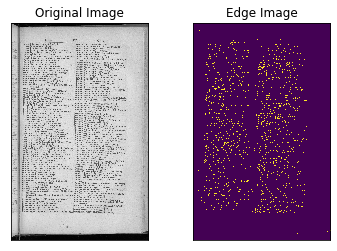

In [6]:
edges = cv2.Canny(img,10,400)

plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges)
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

So I can detect the edges of the text. But, I cannot get the lines. The problem is, the lines separating the columns are too faint to be detected. 

In [ ]:
minLineLength = 100
maxLineGap = 0
lines = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength,maxLineGap)
for x1,y1,x2,y2 in lines[0]:
    cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)

plt.subplot(121),plt.imshow(img_test,cmap = 'gray')
plt.title('Lines Image'), plt.xticks([]), plt.yticks([])

In [ ]:
# Run tesseract
# config argument forces tesseract to engage in orientation and script detection, and uses both legacy and LSTM engines
# https://github.com/tesseract-ocr/tesseract/wiki/ImproveQuality#Borders
result_opencv_string = pytesseract.image_to_string(img, config='--psm 1 --oem 2')
## Get bounding box estimates, lines, confidences, and page numbers
## Useful statistics to have but too annoying to print
####print(pytesseract.image_to_boxes(img))
####print(pytesseract.image_to_data(pic))
## Save to file
directory = os.path.join(test_directory_path + folder_name)
with open(directory + file_name[:-5] + "_opencv2" + ".txt", "w") as f: 
    f.write(result_opencv_string)
    print("Text file saved")

In [ ]:
 """The following chunk was the code used to attempt histogram equalization to improve contrast of the image.
     Histogram equalization was applied after the standard grayscale, dilation, erosion, and scaling transformations.
     However, it is not very useful in the improving text recognition. In fact, the results were worse."""

# #Look at the histogram
# hist,bins = np.histogram(img.flatten(),256,[0,256])
# cdf = hist.cumsum()
# cdf_normalized = cdf * float(hist.max()) / cdf.max()
# plt.plot(cdf_normalized, color = 'b')
# plt.hist(img.flatten(),256,[0,256], color = 'r')
# plt.xlim([0,256])
# plt.legend(('cdf','histogram'), loc = 'upper left')
# plt.show()

# #Run equalization
# equ = cv2.equalizeHist(img)
# res = np.hstack((img,equ)) #stacking images side-by-side
# plt.imshow(res, cmap = 'gray'), plt.axis("off")
# plt.show()

# #Histogram for equalized
# hist1, bins1 = np.histogram(equ.flatten(),256,[0,256])
# cdf1 = hist1.cumsum()
# cdf1_normalized = cdf1 * float(hist1.max()) / cdf1.max()
# plt.plot(cdf1_normalized, color = 'b')
# plt.hist(equ.flatten(),256,[0,256], color = 'r')
# plt.xlim([0,256])
# plt.legend(('cdf1','histogram'), loc = 'upper left')
# plt.show()

# # Run tesseract
# result_opencv_string = pytesseract.image_to_string(equ)
# # Save to file
# directory = os.path.join(test_directory_path + folder_name)
# with open(directory + file_name[:-5] + "_opencv2" + "equ" + ".txt", "w") as f: 
#     f.write(result_opencv_string)
#     print("Text file saved")

# #What about CLAHE
# # create a CLAHE object

# clahe = cv2.createCLAHE()
# cl1 = clahe.apply(img)
# res2 = np.hstack((img,cl1)) #stacking images side-by-side
# plt.imshow(res2, cmap = 'gray'), plt.axis("off")
# plt.show()

# #Histogram for localized contrast change
# hist2, bins2 = np.histogram(cl1.flatten(),256,[0,256])
# cdf2 = hist2.cumsum()
# cdf2_normalized = cdf2 * float(hist2.max()) / cdf2.max()
# plt.plot(cdf2_normalized, color = 'b')
# plt.hist(cl1.flatten(),256,[0,256], color = 'r')
# plt.xlim([0,256])
# plt.legend(('cdf2','histogram'), loc = 'upper left')
# plt.show()

# # Run tesseract
# result_opencv_string = pytesseract.image_to_string(cl1)

# # Save to file
# directory = os.path.join(test_directory_path + folder_name)
# with open(directory + file_name[:-5] + "_opencv2" + "cl1" + ".txt", "w") as f: 
#     f.write(result_opencv_string)
#     print("Text file saved")

This is the preprocessing done by CUSP sans bounding box detection.

In [ ]:
# Preprocess function from previous CUSP team 
# Added in the pivot to return an hOCR object instead

def preprocessImage(test_directory_path):
        """Processes each column image to make it black and white and then using PyTesseract to return results"""

        image = Image.open(test_directory_path + folder_name + file_name)
        thresh = 150
        fn = lambda x : 255 if x > thresh else 0

        # Uses PIL's Image to convert to greyscale
        bw_image = image.convert('L').point(fn, mode='1')
        print(type(bw_image))
        enhanceImage = ImageEnhance.Sharpness(bw_image)
        contrast = ImageEnhance.Contrast(enhanceImage.image)
        brightness = ImageEnhance.Brightness(contrast.image)
        enhancedImage = brightness.image
        
      
        # Recognize text with tesseract for python    
        result = pytesseract.image_to_pdf_or_hocr(enhancedImage, lang="eng", extension = "hocr")
        result_string = pytesseract.image_to_string(enhancedImage)

        
        # save hOCR to file
        ## wb NOT w for hOCR
        directory = os.path.join(test_directory_path + folder_name)
        with open(directory + file_name[:-5] + ".hocr", "wb") as f: 
            f.write(result)
            print("hOCR saved")
        with open(directory + file_name[:-5] + "_bw_" + ".txt", "w") as f: 
            f.write(result_opencv_string)
        return print("Text file saved")

In [ ]:
"""This method will not work because PIL cannot work with an np array that is returned by cv2"""
def preprocessImage_cv2(test_directory_path, folder_name, file_name):
        """Processes each column image to make it black and white and then using PyTesseract to return results"""
        # this path set-up is not ideal but it can be tweaked easily later
        image = cv2.imread(test_directory_path + folder_name + file_name)
        # Rescale the image    
        image = cv2.resize(image, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_CUBIC)
        # Convert to gray    
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)    
        # Apply dilation and erosion to remove some noise    
        kernel = np.ones((1, 1), np.uint8)    
        image = cv2.dilate(image, kernel, iterations=1)    
        image = cv2.erode(image, kernel, iterations=1)
        
        print(type(image))
        
        # Using PIL to further enhance image
        enhanceImage = Ima geEnhance.Sharpness(image)
        contrast = ImageEnhance.Contrast(enhanceImage.image)
        brightness = ImageEnhance.Brightness(contrast.image)
        enhancedImage = brightness.image
        
        # Recognize text with tesseract for python
        # first returns hocr
        # second returns string
        result_opencv_hocr = pytesseract.image_to_pdf_or_hocr(enhancedImage, lang="eng", extension = "hocr")
        result_opencv_string = pytesseract.image_to_string(enhancedImage)
        
        # Batch processing with a single file containing the list of multiple image file paths
        ###print(pytesseract.image_to_string('images.txt'))
        
        # Get bounding box estimates, lines, confidences, and page numbers
        print(pytesseract.image_to_data(image))
        
        # save hOCR to file
        ## wb NOT w for hOCR
        directory = os.path.join(test_directory_path + folder_name)
        with open(directory + file_name[:-5] + "_opencv2" + ".hocr", "wb") as f: 
            f.write(result_opencv_hocr)
            print("hOCR saved")
        with open(directory + file_name[:-5] + "_opencv2" + ".txt", "w") as f: 
            f.write(result_opencv_string)
        return print("Text file saved")

In [ ]:
preprocessImage(test_directory_path)

I have gone ahead and done a comparison between the CUSP's method with PIL and OpenCV 4.1.1. There is no real difference between the two beyond the occassional character and formatting difference. A more substantial test will require running the hOCR column detection script to see which approach's hOCR output is more likely to yield accurate results.

The following chunk attempts deskew. But it is clunky and not quite as effective as the other which lends itself nicely to incorporation within the entire process_image function. 

In [3]:
# Open file        
image = cv2.imread(test_directory_path + folder_name1 + cropped_jpeg)

# Convert to grayscale and flip to ensure black background
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.bitwise_not(gray)

#Set threshold
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

# Compute bounding box that contains all coordinates
# cv2.minAreaRect returns values in range[-90, 0)
# As the rectangle rotates CW, the returned angle tends to 0 so add 90 otherwise invert to make positive
coords = np.column_stack(np.where(thresh>0))
angle = cv2.minAreaRect(coords)[-1]
if angle < -45:
    angle = -(90 + angle)
else:
    angle = -angle

# Get coordinates and size of image
# Affine transformation to correct for skew
# Rotation marix is used to perform transformation
(h, w) = image.shape[:2]
center = (w//2, h//2)
M = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated = cv2.warpAffine(image, M, (w, h),
                        flags = cv2.INTER_CUBIC, borderMode = cv2.BORDER_REPLICATE)

# draw the correction angle on the image so we can validate it
cv2.putText(rotated, "Angle: {:.2f} degrees".format(angle),
            (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
 
# show the output image
print("[INFO] angle: {:.3f}".format(angle))
cv2.imshow("Input", image)
cv2.imshow("Rotated", rotated)
cv2.waitKey(0)

[INFO] angle: 0.121


18